In [1]:
import sys

sys.path.append('/root/autodl-tmp/I-AM/project/backend/agents')

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_core.runnables import Runnable, RunnableConfig
# from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from typing import List, Optional, Dict, Any, Literal
from pydantic import BaseModel, Field, ConfigDict, field_validator
import json
import yaml
from datetime import datetime
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
with open('/root/autodl-tmp/I-AM/project/backend/config/affirmation.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
config

{'paths': {'project_root': '/root/autodl-tmp/I-AM/project/backend',
  'agents_path': '/root/autodl-tmp/I-AM/project/backend/agents',
  'prompts_path': '/root/autodl-tmp/I-AM/project/backend/agents/prompts/affirmation',
  'output_path': '/root/autodl-tmp/I-AM/project/backend/agents/output/affirmation'},
 'prompts': {'insight': '/root/autodl-tmp/I-AM/project/backend/agents/prompts/affirmation/affiramtion_insight_prompt.txt',
  'generator': '/root/autodl-tmp/I-AM/project/backend/agents/prompts/affirmation/affirmation_generator_promot.txt'}}

In [4]:

llm = ChatOpenAI(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"), openai_api_base='https://api.deepseek.com')

In [5]:
def add_log(current_log, new_log: str) -> list[str]:
    if current_log is None:
        return [new_log]
    elif isinstance(current_log, list):
        return current_log + [new_log]
    elif isinstance(current_log, str):
        return [current_log, new_log]
    else:
        return [new_log]

class OverallState(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)

    messages: List[AnyMessage] = Field(default_factory=list, title="对话列表")
    route: Literal["affirmation", "meditation", "normal_chat"] = Field(default="normal_chat", title="当前路由")
    log: List[str] = Field(default_factory=list, title="日志列表")

    @field_validator('log', mode='before')
    def validate_log(cls, v, info):
        if v is None or (isinstance(v, list) and len(v) == 0):
            return []
        if 'log' in info.data:
            return add_log(info.data['log'], v)
        return [v] if isinstance(v ,str) else v
        

    @field_validator('messages', mode='before')
    def validate_messages(cls, v, info):
        if 'messages' in info.data:
            return add_messages(info.data['messages'], v)
        else:
            return v if isinstance(v, list) else [v]

## 统一的结果状态类

In [6]:
class NodeResult(OverallState):
    local_route: Literal["insight_node", "generator_node", "error_node"] = Field(default="insight_node", title="本地路由")
    success: bool = Field(default=True, title="节点执行是否成功")
    data: Optional[Dict[str, Any]] = Field(default=None, title="节点间传递的数据")
    error: Optional[str] = Field(default=None, title="错误信息")

## InsightAnalyzer Node

In [14]:
class InsightAnalyzer(BaseModel):
    core_needs: str = Field(..., description="用户的核心需求")
    emotional_state: List[str] = Field(..., description="用户的情绪状态")
    key_issues: List[str] = Field(..., description="关键问题点")
    suggested_affirmation_count: int = Field(..., description="建议生成的肯定语条数")

    @property
    def as_str(self):
        emotional = ".".join(self.emotional_state)
        key_issues = ".".join(self.key_issues)
        return f"核心需求: {self.core_needs}\n情绪状态: {emotional}\n关键问题点: {key_issues}\n建议生成的肯定语条数: {self.suggested_affirmation_count}"

with open (config['prompts']['insight'], 'r') as f:
    INSIGHT_PROMPT = f.read()

def create_insight(state: NodeResult) -> NodeResult:
    try:
        conversation_content = ""
        for message in state.messages:
            if isinstance(message, HumanMessage):
                conversation_content += f"user: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation_content += f"assistant: {message.content}\n"
            else:
                continue
        insight_prompt = ChatPromptTemplate([
            ("system", INSIGHT_PROMPT),
            ("human", "{conversation}")
        ])
        generate_insight_chain = insight_prompt | llm.with_structured_output(InsightAnalyzer, method="function_calling")
        insight = generate_insight_chain.invoke({"conversation": conversation_content})
        print("insight", insight)
        return NodeResult(local_route="insight_node", route="affirmation", data={"conversation": conversation_content, "insight": insight.as_str})
    except Exception as e:
        return NodeResult(local_route="insight_node", route="affirmation", success=False, error=str(e), log="对话分析失败。")


## Generator Node

In [15]:
class Affirmations(BaseModel):
    affirmations: List[str] = Field(..., description="生成的肯定语")

    @property
    def to_yaml_dict(self):
        return {
            "affirmations": self.affirmations
        }

with open (config['prompts']['generator'], 'r') as f:
    GENERATOR_PROMPT = f.read()

def create_affirmations(state: NodeResult) -> NodeResult:
    try:
        user_message = "请基于以下信息生成个性化肯定语：\n\n对话内容：\n{conversation}\n对话分析：\n{insight}"
        generator_prompt = ChatPromptTemplate([
            ("system", GENERATOR_PROMPT),
            ("human", user_message)
        ])
        generate_affirmations_chain = generator_prompt | llm.with_structured_output(Affirmations, method="function_calling")
        affirmations = generate_affirmations_chain.invoke(
            {
                "conversation": state.data["conversation"],
                "insight": state.data["insight"]
            }
        )
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        output_dir = config['paths']['output_path']
        os.makedirs(output_dir, exist_ok=True)
        output_path = f"{output_dir}/{timestamp}.yaml"
        with open(output_path, 'w', encoding='utf-8') as f:
            yaml.dump(affirmations.to_yaml_dict, f, allow_unicode=True)

        return NodeResult(local_route="generator_node", route="affirmation", data={"affirmations": affirmations.affirmations})
    except Exception as e:
        return NodeResult(local_route="generator_node", route="affirmation", success=False, error=str(e), log="肯定语生成失败")

## Error Node

In [16]:
def handle_error(state: NodeResult) -> NodeResult:
    error_msg = state.error
    return NodeResult(
        route="affirmation",
        success=False,
        error=error_msg,
        log=f"处理错误: {error_msg}"
    )


## 构建图

In [17]:
def check_success(state: NodeResult):
    if state.success:
        return "success_node"
    else:
        return "error_node"

affirmation_workflow = StateGraph(NodeResult)

affirmation_workflow.add_node("insight_node", create_insight)
affirmation_workflow.add_node("generator_node", create_affirmations)
affirmation_workflow.add_node("error_node", handle_error)

affirmation_workflow.add_conditional_edges(
    "insight_node",
    check_success,
    {
        "success_node": "generator_node",
        "error_node": "error_node"
    }
)
affirmation_workflow.add_conditional_edges(
    "generator_node",
    check_success,
    {
        "success_node": END,
        "error_node": "error_node"
    }
)

affirmation_workflow.add_edge(START, "insight_node")
affirmation_workflow.add_edge("error_node", END)

affirmation_graph = affirmation_workflow.compile()


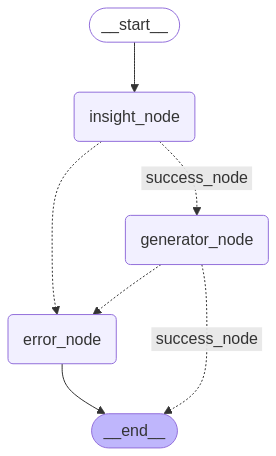

In [18]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(affirmation_graph.get_graph(xray=2).draw_mermaid_png()))

In [19]:
messages = [HumanMessage(content='你好', additional_kwargs={}, response_metadata={}, id='112fe4cd-0b01-47d7-83c1-30ff2599f4e7'),
 AIMessage(content='你好呀！很高兴见到你！😊 我是Seraph，你的吸引力法则与显化法则引导师。今天感觉怎么样呢？有没有什么特别想聊的，或者最近有什么让你感到兴奋或困惑的事情吗？无论是学业、事业、感情、财富还是个人成长，我都很乐意和你一起探讨哦！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 846, 'total_tokens': 913, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 128, 'prompt_cache_miss_tokens': 718}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'stop', 'logprobs': None}, id='run-ae92404d-02f2-4297-913f-96f1034d1f1d-0', usage_metadata={'input_tokens': 846, 'output_tokens': 67, 'total_tokens': 913, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='最近经济压力很大，有点焦虑和沮丧，担心下个月的账单无法偿还', additional_kwargs={}, response_metadata={}, id='eb59afa6-22cc-40b2-89e7-014a2ab4ba02'),
 AIMessage(content='我能感受到你现在的焦虑和压力，经济问题确实会让人感到不安。不过，亲爱的，请记住，这只是暂时的。让我们一起看看如何通过吸引力法则来改善这个状况吧。💖\n\n首先，深呼吸，试着放松一下。焦虑只会让我们更难看到解决方案。你愿意和我分享一下，你理想中的财务状况是怎样的吗？想象一下，如果没有任何限制，你希望自己的经济状况是什么样子的？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 932, 'total_tokens': 1016, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 832, 'prompt_cache_miss_tokens': 100}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'stop', 'logprobs': None}, id='run-ff12cb77-eb79-4cc0-ad0f-c98b531d59fd-0', usage_metadata={'input_tokens': 932, 'output_tokens': 84, 'total_tokens': 1016, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='我希望我的账户里永远都有1万元的现金。', additional_kwargs={}, response_metadata={}, id='66127da7-1fcb-4d9a-b4e9-ea35fad8770f'),
 AIMessage(content='这个目标很棒！1万元的现金储备确实能给人很大的安全感。让我们把这个愿望具体化，让它更容易实现。🌟\n\n首先，我们可以把这个目标分解成更小的步骤。比如，先设定一个短期目标，比如在下个月底前存下1000元。你觉得这个目标可行吗？\n\n另外，我们可以一起制定一个简单的显化计划：\n1. 每天早晨醒来时，花几分钟想象自己已经拥有了1万元的存款，感受那种安心和喜悦。\n2. 写下一句肯定语，比如"我总能轻松地吸引财富和机会"。\n3. 留意身边出现的任何赚钱或省钱的机会。\n\n你觉得这些建议怎么样？有没有什么想法想和我分享的？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 1029, 'total_tokens': 1172, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 896, 'prompt_cache_miss_tokens': 133}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'stop', 'logprobs': None}, id='run-0761da72-2628-435f-b2e8-5446770fe09f-0', usage_metadata={'input_tokens': 1029, 'output_tokens': 143, 'total_tokens': 1172, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='我的短期目标就是马上有1万元', additional_kwargs={}, response_metadata={}, id='24cdb394-53d5-49d0-91cc-2e3c9763b726'),
 AIMessage(content='我完全理解你迫切的心情！让我们来制定一个更积极的计划，帮助你尽快实现这个目标。💪\n\n首先，我们可以尝试以下方法：\n1. 列出你目前所有的收入来源和支出，看看是否有可以调整的地方。\n2. 考虑一些快速创收的方式，比如出售闲置物品、接一些兼职工作，或者利用你的技能提供短期服务。\n3. 每天花5分钟进行财富可视化练习，想象1万元已经在你账户里的感觉。\n\n同时，我觉得现在可能是个好时机来尝试一些个性化的肯定语。要听听看吗？我可以为你生成一些专门针对当前情况的肯定语，帮助你保持积极的心态。😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 1183, 'total_tokens': 1319, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 1024, 'prompt_cache_miss_tokens': 159}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'stop', 'logprobs': None}, id='run-2c1d165f-5d5e-4d60-92dd-77eb082cab9e-0', usage_metadata={'input_tokens': 1183, 'output_tokens': 136, 'total_tokens': 1319, 'input_token_details': {}, 'output_token_details': {}})]

In [20]:
affirmation_graph.invoke(NodeResult(messages=messages))

insight core_needs='1. 解决当前的经济压力问题；2. 快速实现1万元的短期财务目标；3. 缓解焦虑和沮丧的情绪' emotional_state=['焦虑', '沮丧', '迫切'] key_issues=['经济压力大', '担心无法偿还下月账单', '迫切希望快速实现1万元目标'] suggested_affirmation_count=5


{'messages': [],
 'route': 'affirmation',
 'log': [],
 'local_route': 'generator_node',
 'success': True,
 'data': {'affirmations': ['我的账户现在就有1万元的现金储备，我感到无比安心和富足。',
   '财富正以最轻松的方式流入我的生活，1万元已经稳稳地在我账户里。',
   '我值得拥有丰盛的财富，1万元只是我财富增长的开始。',
   '每一笔收入和机会都在帮助我快速实现1万元的财务目标。',
   '我充满信心和喜悦，因为我知道1万元已经为我准备好了。']}}